## Product Survey Score Prediction

Our project is using classification method to do product survey score prediction. We consider that survey score is affected by product characteristics, product price and customer geological information. Therefore, we are joining several datasets to get the features we want.

In [1]:
import pandas as pd
import os.path

import pyspark
from pyspark.sql import SparkSession

from pyspark.sql.functions import udf, col, avg, mean, stddev,explode
from pyspark.sql.types import BooleanType
from pyspark.ml.stat import Correlation

# import data_dict_loader
%matplotlib inline

### 0) Start Spark Session

In [2]:
spark = SparkSession \
    .builder \
    .appName("Spark Data Exploration") \
    .getOrCreate()

print (spark.version)
print (pyspark.version)

mode = 'overwrite'
url = 'jdbc:postgresql://localhost:5432/postgres'
driver = 'org.postgresql.Driver'
properties = {"user": "postgres","password": "postgres","driver":driver}

2.3.2
<module 'pyspark.version' from '/usr/local/lib/python3.6/dist-packages/pyspark/version.py'>


### 1) Load Data 

In [3]:
customer_review_fname = 'customer_reviews_dataset.csv'
products_fname = 'products_dataset.csv'
customer_fname = 'customers_dataset.csv'
order_item_fname = 'order_items_dataset.csv'
order_fname = 'orders_dataset.csv'
product_category_name_translation_fname = 'product_category_name_translation.csv'
customer_review_df = spark.read.load(customer_review_fname,format="csv",inferSchema="true",header="true").cache()
product_df = spark.read.load(products_fname,format="csv",inferSchema="true",header="true").cache()
customer_df = spark.read.load(customer_fname,format="csv",inferSchema="true",header="true").cache()
order_item_df = spark.read.load(order_item_fname,format="csv",inferSchema="true",header="true").cache()
order_df = spark.read.load(order_fname,format="csv",inferSchema="true",header="true").cache()
product_category_name_translation_df = spark.read.load(product_category_name_translation_fname,format="csv",inferSchema="true",header="true").cache()

### 2) Examine Schemas and Counts

In [4]:
print(customer_review_df.count())
customer_review_df.printSchema()

print(product_df.count())
product_df.printSchema()

print(customer_df.count())
customer_df.printSchema()

print(order_item_df.count())
order_item_df.printSchema()

print(order_df.count())
order_df.printSchema()

print(product_category_name_translation_df.count())
product_category_name_translation_df.printSchema()

100000
root
 |-- review_id: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- survey_score: integer (nullable = true)

32951
root
 |-- product_id: string (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_name_lenght: integer (nullable = true)
 |-- product_description_lenght: integer (nullable = true)
 |-- product_photos_qty: integer (nullable = true)
 |-- product_weight_g: integer (nullable = true)
 |-- product_length_cm: integer (nullable = true)
 |-- product_height_cm: integer (nullable = true)
 |-- product_width_cm: integer (nullable = true)

99441
root
 |-- customer_id: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: integer (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)

112650
root
 |-- order_id: string (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 

### 3) Examine Rows

In [5]:
customer_review_df.show(5)

+--------------------+--------------------+------------+
|           review_id|            order_id|survey_score|
+--------------------+--------------------+------------+
|7bc2406110b926393...|73fc7af87114b3971...|           4|
|80e641a11e56f04c1...|a548910a1c6147796...|           5|
|228ce5500dc1d8e02...|f9e4b658b201a9f2e...|           5|
|e64fb393e7b32834b...|658677c97b385a9be...|           5|
|f7c4243c7fe1938f1...|8e6bfb81e283fa7e4...|           5|
+--------------------+--------------------+------------+
only showing top 5 rows



In [6]:
product_df.show(5)

+--------------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+
|          product_id|product_category_name|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|
+--------------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+
|1e9e8ef04dbcff454...|           perfumaria|                 40|                       287|                 1|             225|               16|               10|              14|
|3aa071139cb16b67c...|                artes|                 44|                       276|                 1|            1000|               30|               18|              20|
|96bd76ec8810374ed...|        esporte_lazer|                 46|                       250|    

In [7]:
customer_df.show(5)

+--------------------+--------------------+------------------------+--------------------+--------------+
|         customer_id|  customer_unique_id|customer_zip_code_prefix|       customer_city|customer_state|
+--------------------+--------------------+------------------------+--------------------+--------------+
|06b8999e2fba1a1fb...|861eff4711a542e4b...|                   14409|              franca|            SP|
|18955e83d337fd6b2...|290c77bc529b7ac93...|                    9790|sao bernardo do c...|            SP|
|4e7b3e00288586ebd...|060e732b5b29e8181...|                    1151|           sao paulo|            SP|
|b2b6027bc5c5109e5...|259dac757896d24d7...|                    8775|     mogi das cruzes|            SP|
|4f2d8ab171c80ec83...|345ecd01c38d18a90...|                   13056|            campinas|            SP|
+--------------------+--------------------+------------------------+--------------------+--------------+
only showing top 5 rows



In [8]:
order_item_df.show(5)

+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+
|            order_id|order_item_id|          product_id|           seller_id|shipping_limit_date|price|freight_value|
+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+
|00010242fe8c5a6d1...|            1|4244733e06e7ecb49...|48436dade18ac8b2b...|2017-09-19 09:45:35| 58.9|        13.29|
|00018f77f2f0320c5...|            1|e5f2d52b802189ee6...|dd7ddc04e1b6c2c61...|2017-05-03 11:05:13|239.9|        19.93|
|000229ec398224ef6...|            1|c777355d18b72b67a...|5b51032eddd242adc...|2018-01-18 14:48:30|199.0|        17.87|
|00024acbcdf0a6daa...|            1|7634da152a4610f15...|9d7a1d34a50524090...|2018-08-15 10:10:18|12.99|        12.79|
|00042b26cf59d7ce6...|            1|ac6c3623068f30de0...|df560393f3a51e745...|2017-02-13 13:57:51|199.9|        18.14|
+--------------------+-------------+------------

In [9]:
order_df.show(5)

+--------------------+--------------------+------------+------------------------+-------------------+---------------------------+----------------------------+-----------------------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_carrier_delivery_date|order_customer_delivery_date|order_estimated_delivery_date|
+--------------------+--------------------+------------+------------------------+-------------------+---------------------------+----------------------------+-----------------------------+
|e481f51cbdc54678b...|9ef432eb625129730...|   delivered|     2017-10-02 10:56:33|2017-10-02 11:07:15|        2017-10-04 19:55:00|         2017-10-10 21:25:13|          2017-10-18 00:00:00|
|53cdb2fc8bc7dce0b...|b0830fb4747a6c6d2...|   delivered|     2018-07-24 20:41:37|2018-07-26 03:24:27|        2018-07-26 14:31:00|         2018-08-07 15:27:45|          2018-08-13 00:00:00|
|47770eb9100c2d0c4...|41ce2a54c0b03bf34...|   delivered

In [10]:
product_category_name_translation_df.show(5)

+---------------------+-----------------------------+
|product_category_name|product_category_name_english|
+---------------------+-----------------------------+
|         beleza_saude|                health_beauty|
| informatica_acess...|         computers_accesso...|
|           automotivo|                         auto|
|      cama_mesa_banho|               bed_bath_table|
|     moveis_decoracao|              furniture_decor|
+---------------------+-----------------------------+
only showing top 5 rows



### 4) Merge dataset

In [11]:
customer_review_df = customer_review_df['order_id','survey_score']

product_df = product_df['product_id','product_category_name','product_description_lenght',
            'product_weight_g','product_photos_qty']

customer_df = customer_df['customer_id','customer_state']

order_item_df = order_item_df['order_id','product_id','price','freight_value']

order_df = order_df['order_id','customer_id']

In [12]:
tmp1 = customer_review_df.join(order_df,customer_review_df.order_id == order_df.order_id,'left_outer').drop(order_df.order_id)

tmp1.show(5)

+--------------------+------------+--------------------+
|            order_id|survey_score|         customer_id|
+--------------------+------------+--------------------+
|73fc7af87114b3971...|           4|41dcb106f807e9935...|
|a548910a1c6147796...|           5|8a2e7ef9053dea531...|
|f9e4b658b201a9f2e...|           5|e226dfed6544df5b7...|
|658677c97b385a9be...|           5|de6dff97e5f1ba84a...|
|8e6bfb81e283fa7e4...|           5|5986b333ca0d44534...|
+--------------------+------------+--------------------+
only showing top 5 rows



In [13]:
tmp2 = tmp1.join(customer_df,tmp1.customer_id == customer_df.customer_id,'left_outer').drop(customer_df.customer_id)
tmp2.show(5)

+--------------------+------------+--------------------+--------------+
|            order_id|survey_score|         customer_id|customer_state|
+--------------------+------------+--------------------+--------------+
|73fc7af87114b3971...|           4|41dcb106f807e9935...|            SP|
|a548910a1c6147796...|           5|8a2e7ef9053dea531...|            SP|
|f9e4b658b201a9f2e...|           5|e226dfed6544df5b7...|            BA|
|658677c97b385a9be...|           5|de6dff97e5f1ba84a...|            SC|
|8e6bfb81e283fa7e4...|           5|5986b333ca0d44534...|            SC|
+--------------------+------------+--------------------+--------------+
only showing top 5 rows



In [14]:
tmp3 = tmp2.join(order_item_df,tmp2.order_id == order_item_df.order_id,'left_outer').drop( order_item_df.order_id)
tmp3.show(5)

+--------------------+------------+--------------------+--------------+--------------------+------+-------------+
|            order_id|survey_score|         customer_id|customer_state|          product_id| price|freight_value|
+--------------------+------------+--------------------+--------------+--------------------+------+-------------+
|73fc7af87114b3971...|           4|41dcb106f807e9935...|            SP|fd25ab760bfbba13c...| 185.0|        13.63|
|73fc7af87114b3971...|           4|41dcb106f807e9935...|            SP|fd25ab760bfbba13c...| 185.0|        13.63|
|a548910a1c6147796...|           5|8a2e7ef9053dea531...|            SP|be0dbdc3d67d55727...| 79.79|          8.3|
|f9e4b658b201a9f2e...|           5|e226dfed6544df5b7...|            BA|d1c427060a0f73f6b...| 149.0|        45.12|
|658677c97b385a9be...|           5|de6dff97e5f1ba84a...|            SC|52c80cedd4e90108b...|179.99|        42.85|
+--------------------+------------+--------------------+--------------+-----------------

In [15]:
tmp4= tmp3.join(product_df,tmp3.product_id == product_df.product_id,'left_outer').drop(product_df.product_id).drop(tmp3.product_id).drop(tmp3.order_id).drop(tmp3.customer_id)
tmp4.show(5)

+------------+--------------+------+-------------+---------------------+--------------------------+----------------+------------------+
|survey_score|customer_state| price|freight_value|product_category_name|product_description_lenght|product_weight_g|product_photos_qty|
+------------+--------------+------+-------------+---------------------+--------------------------+----------------+------------------+
|           4|            SP| 185.0|        13.63|        esporte_lazer|                       858|            1300|                 1|
|           4|            SP| 185.0|        13.63|        esporte_lazer|                       858|            1300|                 1|
|           5|            SP| 79.79|          8.3| informatica_acess...|                       493|             245|                 1|
|           5|            BA| 149.0|        45.12| informatica_acess...|                      1893|            6550|                 1|
|           5|            SC|179.99|        42.8

In [16]:
mergedDf = tmp4.join(product_category_name_translation_df,tmp4.product_category_name == product_category_name_translation_df.product_category_name,'left_outer').drop(product_category_name_translation_df.product_category_name).drop(tmp4.product_category_name)
mergedDf.show(5)

+------------+--------------+------+-------------+--------------------------+----------------+------------------+-----------------------------+
|survey_score|customer_state| price|freight_value|product_description_lenght|product_weight_g|product_photos_qty|product_category_name_english|
+------------+--------------+------+-------------+--------------------------+----------------+------------------+-----------------------------+
|           4|            SP| 185.0|        13.63|                       858|            1300|                 1|               sports_leisure|
|           4|            SP| 185.0|        13.63|                       858|            1300|                 1|               sports_leisure|
|           5|            SP| 79.79|          8.3|                       493|             245|                 1|         computers_accesso...|
|           5|            BA| 149.0|        45.12|                      1893|            6550|                 1|         computers_acce

### 5) Drop Missing Values

In [17]:
print(mergedDf.count())
new_merged = mergedDf.dropna(how='any')
print(new_merged.count())

114100
111685


### 6) Summary Statistic

In [18]:
numerical_cols = ['survey_score', 'price', 'freight_value','product_description_lenght', 'product_weight_g', 'product_photos_qty']
new_merged.select(numerical_cols).describe().toPandas().round(2).transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
survey_score,111685,4.018408917938846,1.3976813113533544,1,5
price,111685,120.56640847031595,182.93679423957104,0.85,6735.0
freight_value,111685,20.01440739580049,15.817217676761489,0.0,409.68
product_description_lenght,111685,786.8846219277432,651.7826713195772,4,3992
product_weight_g,111685,2098.11401710167,3753.0166193838927,0,40425
product_photos_qty,111685,2.2067063616421185,1.7194586017380404,1,20


### 7) Correlation

In [19]:
corr = {}
for col in numerical_cols:
    corr[col] = new_merged.stat.corr('survey_score', col)

In [20]:
for w in sorted(corr, key=corr.get, reverse=True):
  print(w, corr[w])

survey_score 1.0
product_photos_qty 0.022600206268197497
product_description_lenght 0.012646795882276782
price -0.0051732329552471035
product_weight_g -0.031151153648561573
freight_value -0.03713373327931963


### 8) Histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05f83984a8>]],
      dtype=object)

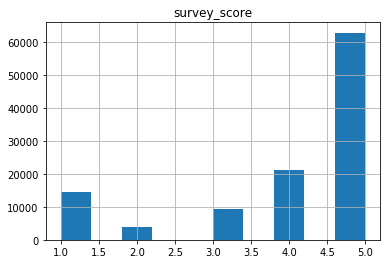

In [21]:
new_merged.select('survey_score').toPandas().hist()

In [22]:
score1 = new_merged.filter(new_merged.survey_score==1)
score2 = new_merged.filter(new_merged.survey_score==2)
score3 = new_merged.filter(new_merged.survey_score==3)
score4 = new_merged.filter(new_merged.survey_score==4)
score5 = new_merged.filter(new_merged.survey_score==5)

In [23]:
new_df = score1.union(score1).union(score1).union(score1)
new_df = new_df.union(score2).union(score2).union(score2).union(score2).union(score2).union(score2).union(score2).union(score2).union(score2).union(score2).union(score2).union(score2).union(score2).union(score2).union(score2)
new_df = new_df.union(score3).union(score3).union(score3).union(score3).union(score3).union(score3)
new_df = new_df.union(score4).union(score4).union(score4)
new_df = new_df.union(score5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f061533cdd8>]],
      dtype=object)

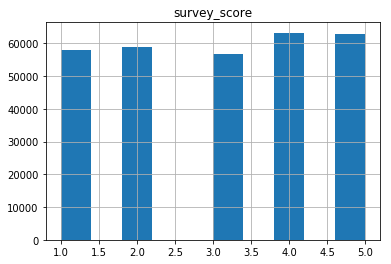

In [24]:
new_df.select('survey_score').toPandas().hist()

### 9) Remove Outliers

In this case, we decide to use 1 as the lower limit and 5 as the upper limit after looking at the summary statistics of “survey score” as well as the histogram. Scores that fall in this range are reasonable and so can be used for classification.

In [25]:
mean_exp = new_df.select(avg(new_df["survey_score"])).collect()[0][0]
std_exp = new_df.select(stddev(new_df["survey_score"])).collect()[0][0]
filtered_df = new_df.filter((new_df['survey_score'] <= 5) & (new_df['survey_score'] >= 1))

print ('Upper limit is ', 5)
print ('Lower limit is ', 1)
print ('Number of outlier rows removed ', new_df.count() - filtered_df.count())
print ('Number of rows rermaining ', filtered_df.count())



Upper limit is  5
Lower limit is  1
Number of outlier rows removed  0
Number of rows rermaining  299300


### 10) Data Prep 

#### a) Create an index column for string column

In the data prep part, in order to add two string columns: “customer_state”  and “product_category_name” into our features using vector assembler, we first transform these two columns from string to double.

In [26]:
from pyspark.ml.feature import StringIndexer

string_col = 'customer_state'
indexedCol = '{}Indexed'.format(string_col)
indexedDf = StringIndexer(inputCol=string_col, outputCol=indexedCol,handleInvalid="skip").fit(filtered_df).transform(filtered_df)
indexedDf.printSchema()

root
 |-- survey_score: integer (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- product_description_lenght: integer (nullable = true)
 |-- product_weight_g: integer (nullable = true)
 |-- product_photos_qty: integer (nullable = true)
 |-- product_category_name_english: string (nullable = true)
 |-- customer_stateIndexed: double (nullable = false)



In [27]:
string_col1 = 'product_category_name_english'
indexedCol1 = '{}Indexed'.format(string_col1)
indexedDf1 = StringIndexer(inputCol=string_col1, outputCol=indexedCol1,handleInvalid="skip").fit(indexedDf).transform(indexedDf)
indexedDf1.printSchema()

root
 |-- survey_score: integer (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- product_description_lenght: integer (nullable = true)
 |-- product_weight_g: integer (nullable = true)
 |-- product_photos_qty: integer (nullable = true)
 |-- product_category_name_english: string (nullable = true)
 |-- customer_stateIndexed: double (nullable = false)
 |-- product_category_name_englishIndexed: double (nullable = false)



#### b) Bucketizer customer state 

In [28]:
row1 = indexedDf1.agg({"customer_stateIndexed": "max"}).collect()[0]
outlierUpperLim = row1["max(customer_stateIndexed)"]

In [29]:
from pyspark.ml.feature import Bucketizer

bucketSize = 5 # TODO
upperLim = int(outlierUpperLim + bucketSize)
splits = list(range(0, upperLim, bucketSize))

bucketizer = Bucketizer(inputCol = 'customer_stateIndexed', outputCol = 'stateBucketized', splits=splits)

# Transform original data into its bucket index.
bucketedData = bucketizer.transform(indexedDf1)

print("Bucketizer output with %d buckets" % (len(bucketizer.getSplits())-1))
bucketedData.show(5)




Bucketizer output with 6 buckets
+------------+--------------+-----+-------------+--------------------------+----------------+------------------+-----------------------------+---------------------+------------------------------------+---------------+
|survey_score|customer_state|price|freight_value|product_description_lenght|product_weight_g|product_photos_qty|product_category_name_english|customer_stateIndexed|product_category_name_englishIndexed|stateBucketized|
+------------+--------------+-----+-------------+--------------------------+----------------+------------------+-----------------------------+---------------------+------------------------------------+---------------+
|           1|            RS| 19.9|        16.05|                       432|             300|                 2|              furniture_decor|                  3.0|                                 1.0|            0.0|
|           1|            RJ| 99.0|        30.53|                       450|            9000|  

#### c) Bucketizer catogery name 

In [30]:
row2 = indexedDf1.agg({"product_category_name_englishIndexed": "max"}).collect()[0]
outlierUpperLim = row2["max(product_category_name_englishIndexed)"]

In [31]:
bucketSize = 5 # TODO
upperLim = int(outlierUpperLim + bucketSize)
splits = list(range(0, upperLim, bucketSize))

bucketizer = Bucketizer(inputCol = 'product_category_name_englishIndexed', outputCol = 'catogoryBucketized', splits=splits)

# Transform original data into its bucket index.
bucketedData = bucketizer.transform(bucketedData)

print("Bucketizer output with %d buckets" % (len(bucketizer.getSplits())-1))
bucketedData.show(5)

Bucketizer output with 14 buckets
+------------+--------------+-----+-------------+--------------------------+----------------+------------------+-----------------------------+---------------------+------------------------------------+---------------+------------------+
|survey_score|customer_state|price|freight_value|product_description_lenght|product_weight_g|product_photos_qty|product_category_name_english|customer_stateIndexed|product_category_name_englishIndexed|stateBucketized|catogoryBucketized|
+------------+--------------+-----+-------------+--------------------------+----------------+------------------+-----------------------------+---------------------+------------------------------------+---------------+------------------+
|           1|            RS| 19.9|        16.05|                       432|             300|                 2|              furniture_decor|                  3.0|                                 1.0|            0.0|               0.0|
|           1|    

#### d) Create a feature vector column 

In [114]:
from pyspark.ml.feature import VectorAssembler

inputCols = ['price','product_description_lenght','freight_value','product_weight_g','product_photos_qty','stateBucketized','catogoryBucketized']
assembler = VectorAssembler(inputCols=inputCols, outputCol="features")#handleInvalid="skip")
data = assembler.transform(bucketedData).drop('customer_state').drop('product_category_name').drop('customer_stateIndexed').drop('product_category_name_englishIndexed').drop('product_category_name_english')
data.show(10)

+------------+-----+-------------+--------------------------+----------------+------------------+---------------+------------------+--------------------+
|survey_score|price|freight_value|product_description_lenght|product_weight_g|product_photos_qty|stateBucketized|catogoryBucketized|            features|
+------------+-----+-------------+--------------------------+----------------+------------------+---------------+------------------+--------------------+
|           1| 19.9|        16.05|                       432|             300|                 2|            0.0|               0.0|[19.9,432.0,16.05...|
|           1| 99.0|        30.53|                       450|            9000|                 1|            0.0|               1.0|[99.0,450.0,30.53...|
|           1| 99.0|        30.53|                       450|            9000|                 1|            0.0|               1.0|[99.0,450.0,30.53...|
|           1| 39.5|        48.64|                       300|             35

In [33]:
inputCols1 = ['survey_score','price','product_description_lenght','freight_value','product_weight_g','product_photos_qty','stateBucketized','catogoryBucketized']
assembler = VectorAssembler(inputCols=inputCols1, outputCol="features")#handleInvalid="skip")
Corrdata = assembler.transform(bucketedData).drop('customer_state').drop('product_category_name').drop('customer_stateIndexed').drop('product_category_name_englishIndexed').drop('product_category_name_english')
Corrdata.show(10)

+------------+-----+-------------+--------------------------+----------------+------------------+---------------+------------------+--------------------+
|survey_score|price|freight_value|product_description_lenght|product_weight_g|product_photos_qty|stateBucketized|catogoryBucketized|            features|
+------------+-----+-------------+--------------------------+----------------+------------------+---------------+------------------+--------------------+
|           1| 19.9|        16.05|                       432|             300|                 2|            0.0|               0.0|[1.0,19.9,432.0,1...|
|           1| 99.0|        30.53|                       450|            9000|                 1|            0.0|               1.0|[1.0,99.0,450.0,3...|
|           1| 99.0|        30.53|                       450|            9000|                 1|            0.0|               1.0|[1.0,99.0,450.0,3...|
|           1| 39.5|        48.64|                       300|             35

In [34]:
from pyspark.ml.stat import Correlation

# Get correlation DataFrame, collect and extract a pyspark.mllib.linalg.DenseMatrix, convert to array 
corr_mat = Correlation.corr(Corrdata, 'features').collect()[0][0].toArray()

# Create Pandas DataFrame from correlation matrix
corr_mat = pd.DataFrame(corr_mat, index=inputCols1, columns=inputCols1)
corr_mat.head(len(inputCols1))

,survey_score,price,product_description_lenght,freight_value,product_weight_g,product_photos_qty,stateBucketized,catogoryBucketized
survey_score,1.000000,-0.007460,0.019482,-0.036840,-0.029294,0.027961,-0.031953,0.022043
price,-0.007460,1.000000,0.194829,0.417537,0.350539,0.053355,0.067726,0.095780
product_description_lenght,0.019482,0.194829,1.000000,0.095279,0.066782,0.119988,0.030361,0.027836
freight_value,-0.036840,0.417537,0.095279,1.000000,0.618671,0.012162,0.294271,0.088617
product_weight_g,-0.029294,0.350539,0.066782,0.618671,1.000000,0.008361,-0.001902,0.138210
product_photos_qty,0.027961,0.053355,0.119988,0.012162,0.008361,1.000000,0.043012,0.084111
stateBucketized,-0.031953,0.067726,0.030361,0.294271,-0.001902,0.043012,1.000000,0.003852
catogoryBucketized,0.022043,0.095780,0.027836,0.088617,0.138210,0.084111,0.003852,1.000000


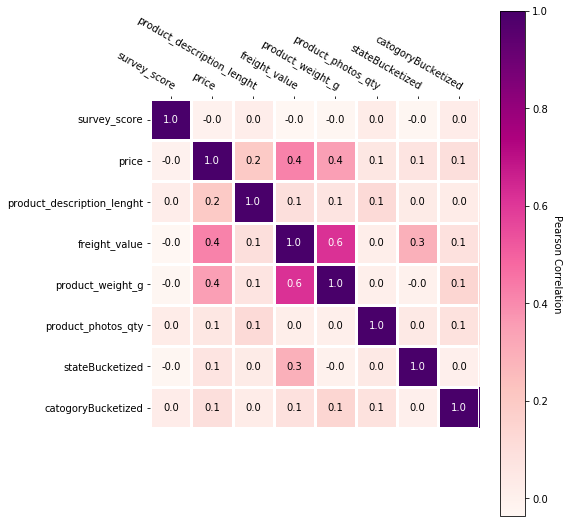

In [67]:
import utils
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))

im, cbar = utils.heatmap(corr_mat, inputCols1, inputCols1, ax=ax,
                         cmap="RdPu", cbarlabel="Pearson Correlation")

texts = utils.annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

#### e) Spit the dataset into train and test

In [36]:
trainDf, testDf = data.randomSplit([0.75, 0.25])
trainDf.show(5)
testDf.show(5)

+------------+-----+-------------+--------------------------+----------------+------------------+---------------+------------------+--------------------+
|survey_score|price|freight_value|product_description_lenght|product_weight_g|product_photos_qty|stateBucketized|catogoryBucketized|            features|
+------------+-----+-------------+--------------------------+----------------+------------------+---------------+------------------+--------------------+
|           1| 4.99|        37.04|                       421|             200|                 2|            2.0|               2.0|[4.99,421.0,37.04...|
|           1| 5.99|        16.11|                       359|             150|                 4|            0.0|               2.0|[5.99,359.0,16.11...|
|           1|  6.0|         7.78|                       895|              50|                 1|            0.0|               0.0|[6.0,895.0,7.78,5...|
|           1|  6.9|        15.65|                       137|             10

### 11) Train and Evaluate Decision Tree Classifier

#### a) Fit the model

In [37]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

treeModel = DecisionTreeClassifier(labelCol='survey_score', featuresCol='features', maxDepth=15)

# Fit the model
modelNoTuning = treeModel.fit(trainDf)

In [38]:
print(modelNoTuning)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_421ea909e95ff44890d2) of depth 15 with 10175 nodes


In [39]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    varlist = varlist[['name','score']]
    return(varlist.sort_values('score', ascending = False))

In [40]:
ExtractFeatureImp(modelNoTuning.featureImportances, trainDf, "features").head(10)

,name,score
0,price,0.247800
1,product_description_lenght,0.203116
2,freight_value,0.166244
3,product_weight_g,0.166190
6,catogoryBucketized,0.110312
4,product_photos_qty,0.065850
5,stateBucketized,0.040488


#### b) Predict and Evaluate

In [41]:
predDf = modelNoTuning.transform(testDf)

evaluator = MulticlassClassificationEvaluator(
    labelCol='survey_score', predictionCol="prediction", metricName="accuracy")

accuracy_pred= evaluator.evaluate(predDf)

print("Test Acc = %g " % (accuracy_pred))

Test Acc = 0.380778 


### 12) Train and Evaluate Decision Tree Classifier using Validation Data

#### a) Use validation data to select the best model

In [49]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

paramGrid = ParamGridBuilder() \
    .addGrid(treeModel.maxDepth, [5,10,15]) \
    .build()

In [50]:
evaluator = MulticlassClassificationEvaluator(labelCol='survey_score', 
                                              predictionCol='prediction', 
                                              metricName='accuracy')

tvs = TrainValidationSplit (estimator=treeModel,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.7)

In [51]:
tree = tvs.fit(trainDf)

In [52]:
print(tree.bestModel)
# print(tree.bestModel.toDebugString)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4f5eace10bd75cdea39e) of depth 15 with 13627 nodes


#### b) Predict and Evaluate

In [53]:
predDf = tree.transform(testDf)

evaluator = MulticlassClassificationEvaluator(
    labelCol='survey_score', predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predDf)
print("Test Acc = %g " % (accuracy))

predDf.show(10)

Test Acc = 0.423728 
+------------+-----+-------------+--------------------------+----------------+------------------+---------------+------------------+--------------------+--------------------+--------------------+----------+
|survey_score|price|freight_value|product_description_lenght|product_weight_g|product_photos_qty|stateBucketized|catogoryBucketized|            features|       rawPrediction|         probability|prediction|
+------------+-----+-------------+--------------------------+----------------+------------------+---------------+------------------+--------------------+--------------------+--------------------+----------+
|           1|  6.0|         7.78|                       895|              50|                 1|            0.0|               0.0|[6.0,895.0,7.78,5...|[0.0,7.0,0.0,10.0...|[0.0,0.3888888888...|       3.0|
|           1|  6.9|        15.65|                       137|             100|                 2|            1.0|               1.0|[6.9,137.0,15.65,..

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f061528a390>]],
      dtype=object)

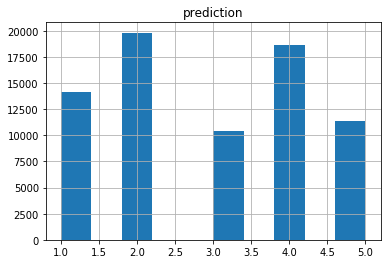

In [43]:
predDf.select('prediction').toPandas().hist()

In [44]:
t = [5] * 60000 + [4] *50 + [3] *26+ [2] *79+[5]*100

In [45]:
df = pd.DataFrame(t)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05f80d62e8>]],
      dtype=object)

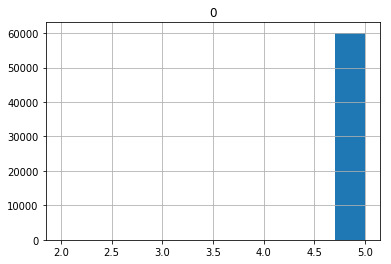

In [46]:
df.hist()

In [47]:
predDfpandas = predDf.toPandas()

In [48]:
right = 0
wrong = 0
for i in range(0, len(predDfpandas)):
    if predDfpandas['survey_score'][i] == predDfpandas['prediction'][i] or  predDfpandas['survey_score'][i] == predDfpandas['prediction'][i] +1 or predDfpandas['survey_score'][i] == predDfpandas['prediction'][i] -1:
        right += 1
    else:
        wrong += 1

In [49]:
right/(right+wrong)

0.6365540295622055

###  13) More Evaluation

#### a) confusion matrix

In [50]:
from sklearn.metrics import confusion_matrix

labelCol = 'survey_score'
classes = predDf.select(labelCol).groupBy(labelCol)\
                        .count().sort('count', ascending=False).toPandas()
classLabels = classes[labelCol].values.tolist()

yTrue = predDf.select('survey_score').toPandas()
yPred = predDf.select('prediction').toPandas()
cnfMatrix = confusion_matrix(yTrue, yPred)
cnfMatrix

array([[5546, 2612, 1498, 3066, 1892],
       [1478, 8849,  802, 2247, 1419],
       [2107, 2491, 4310, 3135, 1922],
       [2450, 2937, 1800, 5921, 2439],
       [2600, 2933, 2001, 4295, 3737]])

Confusion matrix, without normalization
[[5546 2612 1498 3066 1892]
 [1478 8849  802 2247 1419]
 [2107 2491 4310 3135 1922]
 [2450 2937 1800 5921 2439]
 [2600 2933 2001 4295 3737]]


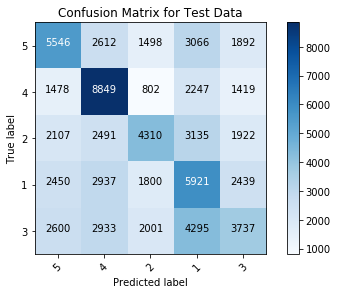

In [68]:
from plot_helper import plot_confusion_matrix
import matplotlib.pyplot as plt

plt.figure()
plot_confusion_matrix(cnfMatrix, title="Confusion Matrix for Test Data", classes=classLabels)
plt.show()

Normalized confusion matrix
[[0.37949911 0.17873272 0.10250445 0.20979882 0.1294649 ]
 [0.09989861 0.59810747 0.0542075  0.15187563 0.09591078]
 [0.15087719 0.17837451 0.30862871 0.2244898  0.13762979]
 [0.15758667 0.18891104 0.11577796 0.38084518 0.15687914]
 [0.16703071 0.18842349 0.1285494  0.27592188 0.24007452]]


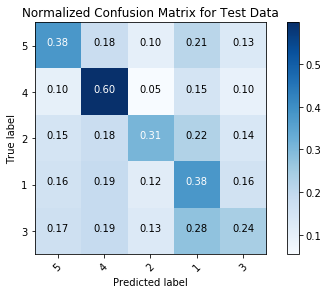

In [69]:
plt.figure()
plot_confusion_matrix(cnfMatrix, title="Normalized Confusion Matrix for Test Data",
                      classes=classLabels, normalize=True)
plt.show()

#### b) Classification report

In [52]:
len(yTrue)

74487

In [53]:
from sklearn.metrics import classification_report
classLabels = [str(cla) for cla in classLabels]
# print (classification_report(yTrue, yPred, target_names=labelClasses))
print (classification_report(yTrue, yPred, target_names=classLabels))

              precision    recall  f1-score   support

           5       0.39      0.38      0.39     14614
           4       0.45      0.60      0.51     14795
           2       0.41      0.31      0.35     13965
           1       0.32      0.38      0.35     15547
           3       0.33      0.24      0.28     15566

   micro avg       0.38      0.38      0.38     74487
   macro avg       0.38      0.38      0.37     74487
weighted avg       0.38      0.38      0.37     74487



## 14) try Gradient-boosted tree classifier
in order to get a comparatively balanced dataset for binary classification using Gradient-boosted tree classifier, we regard score<3 as a bad score and label is as "0", while scores >3 are labeled as "1".

In [121]:
data1=data.filter(data.survey_score!=3)
from pyspark.sql import functions as F
update_func = (F.when(F.col('survey_score') <3,0)
                .otherwise(1))
data1 = data1.withColumn('survey_score_trans', update_func)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05eed8d438>]],
      dtype=object)

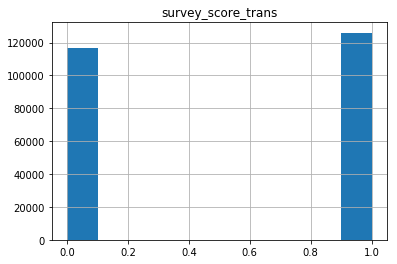

In [122]:
data1.select('survey_score_trans').toPandas().hist()

In [123]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [124]:
labelIndexer = StringIndexer(inputCol="survey_score_trans", outputCol="indexedsurvey_score").fit(data1)

In [125]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data1)

In [126]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data1.randomSplit([0.75, 0.25])

In [127]:
# Train a GBT model.
gbt = GBTClassifier(labelCol="indexedsurvey_score", featuresCol="indexedFeatures", maxIter=10)

In [128]:
# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])


In [129]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [130]:
# Make predictions.
predictions = model.transform(testData)

In [131]:
# Select example rows to display.
predictions.select("prediction", "indexedsurvey_score", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedsurvey_score", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % (accuracy))

gbtModel = model.stages[2]
print(gbtModel)  # summary only

+----------+-------------------+--------------------+
|prediction|indexedsurvey_score|            features|
+----------+-------------------+--------------------+
|       1.0|                1.0|[7.45,338.0,14.1,...|
|       1.0|                1.0|[7.45,338.0,14.1,...|
|       1.0|                1.0|[7.45,338.0,14.1,...|
|       0.0|                1.0|[8.9,456.0,8.27,5...|
|       0.0|                1.0|[8.99,92.0,23.51,...|
+----------+-------------------+--------------------+
only showing top 5 rows

Test Accuracy = 0.573129
GBTClassificationModel (uid=GBTClassifier_4e26aa79aced68c757bd) with 10 trees


As we can tell from the accuracy, the GBT model doesn't work well, its accuracy is just better than a random guess.

### 14) Stop Spark Session

In [ ]:
spark.stop()